In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42145,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:35607,Total threads: 8
Dashboard: http://127.0.0.1:34379/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:39219,


___________
# 1. Read Zach's data, and store as .nc files every one hour (9415 .nc files) 

In [3]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/meddy/yuxlong5/data/LLC4320/'
# the path where the data will be re-stored
out_dir_nc = '/meddy/yuxlong5/data/data_store/'

# variable 
v = 'V'

In [5]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201x52.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(52,201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['depth','lat_g','lon'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


# 2. Add coordinates and put variables into one xarray file

In [7]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', combine="nested")
print(ds)

Number of files processed: 9415
CPU times: user 14.2 s, sys: 1.52 s, total: 15.7 s
Wall time: 21.1 s
<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat_g: 201, lon: 177)
Dimensions without coordinates: time, depth, lat_g, lon
Data variables:
    V        (time, depth, lat_g, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [8]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [9]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [10]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat_g: 201, lon: 177)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat_g, lon
Data variables:
    V        (time, depth, lat_g, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [11]:
chunks = {'time': 9415, 'lat_g': 1, 'lon': 177, 'depth':1}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat_g: 201, lon: 177)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat_g, lon
Data variables:
    V        (time, depth, lat_g, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>


In [12]:
out_dir_zarr = '/meddy/yuxlong5/data/data_zarr/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

/home/yuxlong5/miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 13.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 55.5 s, sys: 8.86 s, total: 1min 4s
Wall time: 2min 48s


# Read re-chunked data

In [13]:
out_dir_zarr = '/meddy/yuxlong5/data/data_zarr/'

ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat_g: 201, lon: 177)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat_g, lon
Data variables:
    V        (time, depth, lat_g, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

 data size: 69.7 GB


CPU times: user 81.8 ms, sys: 17.1 ms, total: 98.9 ms
Wall time: 195 ms


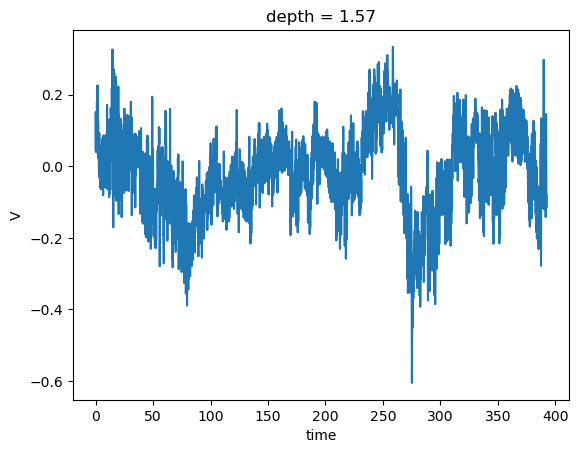

In [14]:
%time ds[v].isel(depth=1, lat_g=slice(50,100), lon=slice(50,100)).mean(dim=['lat_g','lon']).plot()

In [16]:
cluster.scheduler.close()

<coroutine object Scheduler.close at 0x7f6028719d40>

In [19]:
# the path where the data will be re-stored
LLC_data_folder_data_store = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
filename_grid = sorted(glob(LLC_data_folder_data_store+'Grid.nc')) 

grid = xr.open_mfdataset(filename_grid)
grid

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177)
Coordinates:
    XC       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YC       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    XG       (lat_g, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YG       (lat_g, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    CS       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    SN       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    Depth    (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dxC      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dxG      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG      (lat, lon_g) float32 dask.array<shape=(201, 177), chunk

In [20]:
lat = grid.YC.isel(lon=1)
lon = grid.XC.isel(lat=1)

lat_g = grid.YG.isel(lon_g=1)
lon_g = grid.XG.isel(lat_g=1)

In [26]:
lat_g = grid.YG.isel(lon_g=1)
lat_g

<xarray.DataArray 'YG' (lat_g: 201)>
dask.array<shape=(201,), dtype=float32, chunksize=(201,)>
Coordinates:
    XG       (lat_g) float32 dask.array<shape=(201,), chunksize=(201,)>
    YG       (lat_g) float32 dask.array<shape=(201,), chunksize=(201,)>
  * lat_g    (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...
    lon_g    float32 -18.020834

# old

In [6]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201x52.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(52,201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['depth','lat','lon'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


# 2. Add coordinates and put variables into one xarray file

In [7]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
print(ds)

Number of files processed: 9415
CPU times: user 28.5 s, sys: 24.9 s, total: 53.4 s
Wall time: 1min
<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Dimensions without coordinates: depth, lat, lon, time
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [8]:
LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['lat','lon'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [9]:
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)

LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['lat','lon'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [10]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [11]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [12]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds = ds.assign_coords(lat=lat) 
ds = ds.assign_coords(lon=lon)
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) >f4 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 -17.947916 ...
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [13]:
ds = ds.assign_coords(dtime=xr.DataArray(iters_to_date(np.arange(len(filenames))), dims=['time']))
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) >f4 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 -17.947916 ...
    dtime    (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ...
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


# 3. save as one .zarr file

In [14]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

file_out = out_dir_zarr+'/%s_total.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 37.3 s, sys: 2.2 s, total: 39.5 s
Wall time: 44.7 s


In [15]:
ds = xr.open_zarr(out_dir_zarr+v+'_total.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(9415,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>

 data size: 69.7 GB


CPU times: user 22.7 s, sys: 720 ms, total: 23.4 s
Wall time: 23.3 s


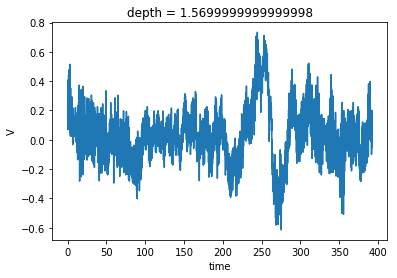

In [16]:
%time ds[v].isel(depth=1, lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [18]:
cluster.scheduler.close()

<Future finished result=None>